In [1]:
%load_ext autoreload

%autoreload 2
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ruspy.estimation.criterion_function import get_criterion_function
from ruspy.model_code.demand_function import get_demand
from estimagic import minimize

## Short Tutorial on the Use of ruspy

As opposed to the other replication notebook, here we do not actually replicate a whole paper but just an aspect of Rust (1987) in order to show how the key objects and functions for the estimation and the demand function derivation are used in the ruspy package.

### Estimation with the Nested Fixed Point Algorithm

Here, we replicate the results in Table IX of Rust (1987) for the buses of group 4. For different data sets, you can either prepare them from raw data yourself (the raw data can be found [here](https://editorialexpress.com/jrust/research.html)) or visit the [data repository of OpenSourceEconomics](https://github.com/OpenSourceEconomics/zurcher-data) for Rust's (1987) data which allows to prepare the original data the way it is needed for the ruspy package. In order to estimate the parameters of the model we first load the data below.

In [2]:
data = pd.read_pickle("group_4.pkl")
data

state   mileage usage  decision
Bus_ID period                                
5297   0          0    2353.0   NaN         0
       1          1    6299.0   1.0         0
       2          2   10479.0   1.0         0
       3          3   15201.0   1.0         0
       4          4   20326.0   1.0         0
...             ...       ...   ...       ...
5333   112       68  342004.0   0.0         0
       113       68  343654.0   0.0         0
       114       69  345631.0   1.0         0
       115       69  347549.0   0.0         0
       116       69  347549.0   0.0         0

[4329 rows x 4 columns]

The data is the first ingredient for the function ``get_criterion_function`` of ruspy and the second one is the initialization dictionairy (have a look at the documentation for the all possible keys). The estimation procedure, here, assumes the model to have the specifications as determined in the key "model_specifications". In order to use the Nested Fixed Point Algorithm, we specify it as "method" key of the initialization dictionairy. We can further assign specific algorithmic details in the subdictionary "alg_details". More information on the algorithmic details as well as default values can also be found in the documentation.

In [3]:
init_dict_nfxp = {
    "model_specifications": {
        "discount_factor": 0.9999,
        "num_states": 90,
        "maint_cost_func": "linear",
        "cost_scale": 1e-3,
    },
    "method": "NFXP"
}

The above two elements are now given to the ``get_criterion_function`` function. The function specifies the criterion function (negative log-likelihood function) and its derivative needed for the cost parameter estimation. Additionally, it returns a dictionairy containing the results of the estimation of the transition probabilities.

In [4]:
criterion_func, criterion_dev, result_transitions_nfxp = get_criterion_function(init_dict_nfxp, data)

In [5]:
result_transitions_nfxp

{'trans_count': array([1682, 2555,   55]),
 'x': array([0.39189189, 0.59529357, 0.01281454]),
 'fun': 3140.570557093825}

In order to estimate the cost parameters, the criterion function and its derivative need to be minimized. 
Here we use the``minimize`` function of estimagic together with the BFGS algorithm of scipy.

In [6]:
result_nfxp = minimize(
    criterion=criterion_func,
    params=np.array([2,10]),
    algorithm="scipy_bfgs",
    derivative=criterion_dev,
)
result_nfxp

Minimize with 2 free parameters terminated successfully after 27 criterion evaluations, 27 derivative evaluations and 24 iterations.

The value of criterion improved from 1567.6162300270314 to 163.58428365680274.

The scipy_bfgs algorithm reported: Optimization terminated successfully.

Independent of the convergence criteria used by scipy_bfgs, the strength of convergence can be assessed by the following criteria:

                             one_step     five_steps 
relative_criterion_change   1.03e-13***  0.0003636   
relative_params_change     4.682e-07*      0.04934   
absolute_criterion_change  1.685e-11***    0.05948   
absolute_params_change     4.172e-06*        0.361   

(***: change <= 1e-10, **: change <= 1e-8, *: change <= 1e-5. Change refers to a change between accepted steps. The first column only considers the last step. The second column considers the last five steps.)

The optimization algorithm successfully terminated.

In [7]:
result_nfxp.success

True

As expected, the results below reveal that we find the same parameter estimates as Rust (1987) in Table IX.

In [8]:
result_nfxp.params

array([10.0749422 ,  2.29309298])

### Estimation with Mathematical Programming with Equilibrium Constraints

We now estimate the model for the same data set with the same specifications. Here, we have to specify that we want to use "MPEC" in the "method" key.

In [9]:
init_dict_mpec = {
    "model_specifications": {
        "discount_factor": 0.9999,
        "num_states": 90,
        "maint_cost_func": "linear",
        "cost_scale": 1e-3,
    },
    "method": "MPEC"
}

We hand the above dictionairy and the data to the function ``get_criterion_function``, which for MPEC returns the criterion function, its derivative, the contraint function, the derivative of the constraint function and the transition results. The result of the transition probability estimation is the same as for NFXP.

In [10]:
criterion_func, criterion_dev, constraint, constraint_dev, result_transitions_mpec = get_criterion_function(init_dict_mpec, data)
result_transitions_mpec

{'trans_count': array([1682, 2555,   55]),
 'x': array([0.39189189, 0.59529357, 0.01281454]),
 'fun': 3140.570557093825}

Again, we use the ``minimize`` function of estimagic in order to estimate the cost parameters for MPEC. Additionally, we choose the SLSQP algorithm for nonlinearly constrained gradient-based optimization for the minimization process.

In [11]:
num_states = init_dict_mpec["model_specifications"]["num_states"]
init_params = np.array([2, 10])
x0 = np.zeros(num_states + init_params.shape[0], dtype=float)
x0[num_states:] = init_params

# minimize criterion function
result_mpec = minimize(
    criterion=criterion_func,
    params=x0,
    algorithm="nlopt_slsqp",
    derivative=criterion_dev,
    constraints={
        "type": "nonlinear",
        "func": constraint,
        "derivative": constraint_dev,
        "value": np.zeros(num_states, dtype=float),
    },
)

We arrive at the same results again. As MPEC also takes the expected values as parameters, the parameter vector in the cost parameter results also contains the estimated expected values at the beginning.

In [12]:
result_mpec.success

True

In [13]:
result_mpec.params[num_states:]

array([10.07496416,  2.29310354])

### Deriving the Implied Demand Function

From the estimated parameters above (or generally from any parameters) we can now derive the implied demand function with ruspy as described in Rust (1987). For this we have to specify a dictionairy that describes the grid of replacement cost for which the expected demand is supposed to be calculated. As the demand calculation involves solving a fixed point one needs to specify the stopping tolerance for contraction iterations. Additionally, one passes for how many months, here 12, and how many buses (37) the implied demand is derived. Additionally, one has to supply the cost and transition parameters and pass it in separately to ``get_demand`` function that coordinates the demand derivation.

In [14]:
demand_dict = {
    "RC_lower_bound": 4,
    "RC_upper_bound": 13,
    "demand_evaluations": 100,
    "tolerance": 1e-10,
    "num_periods": 12,
    "num_buses": 37,
}
demand_params = np.concatenate((result_transitions_nfxp["x"], result_nfxp.params))

Lastly, the information for which model specification the demand is supposed to be calculated has to be passed in as a dictionairy. If, as in our case, the parameters come from previously run estimation, we can just pass in the initialization dictionairy used for the estimation. From this the ``get_demand`` function extracts the model information by using the "model_specifications" key. This means that it is sufficient to pass in a dictionairy that has this key and under which there is the information as requested for the initialization dictionairy. The "method" key is not needed.

Below we now run the demand estimation and give out the results for the first few replacement costs.

In [15]:
demand = get_demand(init_dict_nfxp, demand_dict, demand_params)
demand.head()

,demand,success
RC,,
4.000000,15.975931,Yes
4.090909,15.340571,Yes
4.181818,14.750837,Yes
4.272727,14.202752,Yes
4.363636,13.692714,Yes


To get a sense of how the overall demand function looks like, we plot the above results across the whole grid of replacement costs that we specified before.

Text(0, 0.5, 'Expected Annual Demand')

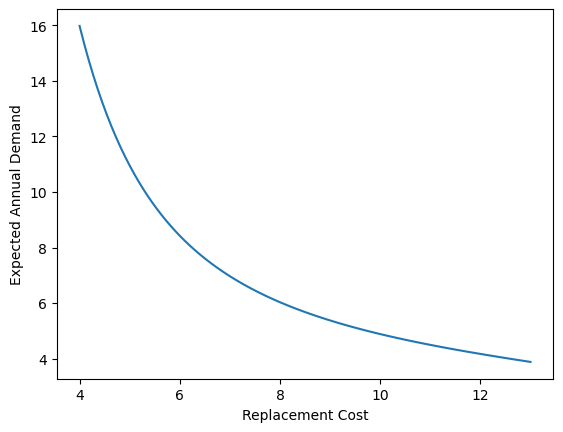

In [16]:
plt.plot(demand.index.to_numpy(), demand["demand"].astype(float).to_numpy())
plt.xlabel("Replacement Cost")
plt.ylabel("Expected Annual Demand")